**Mount Drive & Start Spark**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BTS_Feature_Engineering") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.sql.parquet.compression.codec", "snappy") \
    .getOrCreate()

print("Spark Version:", spark.version)

Mounted at /content/drive
Spark Version: 4.0.2


**Configure Paths**

In [ ]:
import os

PARQUET_PATH  = "/content/drive/MyDrive/Machine Learning and Big Data/parquet_data"
FEATURES_PATH = "/content/drive/MyDrive/Machine Learning and Big Data/features_parquet"
TABLEAU_PATH  = "/content/drive/MyDrive/Machine Learning and Big Data/tableau_exports"
CHECKPOINT    = "/content/drive/MyDrive/Machine Learning and Big Data/checkpoints"
LOGS_PATH     = "/content/drive/MyDrive/Machine Learning and Big Data/logs"

for path in [FEATURES_PATH, TABLEAU_PATH, CHECKPOINT, LOGS_PATH]:
    os.makedirs(path, exist_ok=True)

spark.sparkContext.setCheckpointDir(CHECKPOINT)

print("Paths configured")
print("Input  :", PARQUET_PATH)
print("Output :", FEATURES_PATH)

Paths configured
Input  : /content/drive/MyDrive/Machine Learning and Big Data/parquet_data
Output : /content/drive/MyDrive/Machine Learning and Big Data/features_parquet


**Load Parquet Data**

In [ ]:
from pyspark.sql import functions as F
from pyspark import StorageLevel

df = spark.read.parquet(PARQUET_PATH)

print("Data loaded from Parquet")
print("  Rows      :", df.count())
print("  Columns   :", len(df.columns))

df.persist(StorageLevel.MEMORY_AND_DISK)
print("DataFrame persisted to MEMORY_AND_DISK")

Data loaded from Parquet
  Rows      : 3461319
  Columns   : 110
DataFrame persisted to MEMORY_AND_DISK


**Drop Irrelevant Columns**

In [ ]:
drop_cols = [
    "_c109",
    "Div1Airport", "Div1AirportID", "Div1AirportSeqID",
    "Div1WheelsOn", "Div1TotalGTime", "Div1LongestGTime",
    "Div1WheelsOff", "Div1TailNum",
    "Div2Airport", "Div2AirportID", "Div2AirportSeqID",
    "Div2WheelsOn", "Div2TotalGTime", "Div2LongestGTime",
    "Div2WheelsOff", "Div2TailNum",
    "Div3Airport", "Div3AirportID", "Div3AirportSeqID",
    "Div3WheelsOn", "Div3TotalGTime", "Div3LongestGTime",
    "Div3WheelsOff", "Div3TailNum",
    "Div4Airport", "Div4AirportID", "Div4AirportSeqID",
    "Div4WheelsOn", "Div4TotalGTime", "Div4LongestGTime",
    "Div4WheelsOff", "Div4TailNum",
    "Div5Airport", "Div5AirportID", "Div5AirportSeqID",
    "Div5WheelsOn", "Div5TotalGTime", "Div5LongestGTime",
    "Div5WheelsOff", "Div5TailNum",
    "DivAirportLandings", "DivReachedDest", "DivActualElapsedTime",
    "DivArrDelay", "DivDistance",
    "FirstDepTime", "TotalAddGTime", "LongestAddGTime",
    "Tail_Number", "Flight_Number_Reporting_Airline",
    "OriginAirportSeqID", "OriginCityMarketID",
    "DestAirportSeqID", "DestCityMarketID",
    "OriginStateFips", "DestStateFips",
    "OriginWac", "DestWac",
    "DOT_ID_Reporting_Airline",
    "IATA_CODE_Reporting_Airline",
    "ArrTimeBlk", "DepTimeBlk",
    "CancellationCode", "Flights",
]

existing_drop = [c for c in drop_cols if c in df.columns]
df = df.drop(*existing_drop)

print(f"Dropped {len(existing_drop)} irrelevant columns")
print(f"Remaining columns: {len(df.columns)}")

Dropped 65 irrelevant columns
Remaining columns: 45


In [ ]:
total_rows  = df.count()
null_summary = []

for col_name in df.columns:
    null_count = df.filter(F.col(col_name).isNull()).count()
    pct        = round(100 * null_count / total_rows, 2)
    null_summary.append((col_name, null_count, pct))

# Sort by null count descending
null_summary = sorted(null_summary, key=lambda x: -x[1])

# Print report
print(f"Null Value Summary — Post Column Drop")
print(f"  Total Rows    : {total_rows:,}")
print(f"  Total Columns : {len(df.columns)}")
print(f"\n{'Column':<40} {'Null Count':>12} {'% Missing':>12}")
print("-" * 67)

null_cols = 0
for col_name, null_count, pct in null_summary:
    if null_count > 0:
        status = "  ← fill 0" if col_name in [
            "CarrierDelay", "WeatherDelay", "NASDelay",
            "SecurityDelay", "LateAircraftDelay",
            "DepDelay", "DepDelayMinutes", "DepDel15",
            "ArrDelay", "ArrDelayMinutes", "ArrDel15",
            "TaxiOut", "TaxiIn", "AirTime", "ActualElapsedTime"
        ] else "  ← drop row"
        print(f"  {col_name:<38} {null_count:>12,} {pct:>11.2f}%  {status}")
        null_cols += 1

print("-" * 67)
print(f"\n  Columns with nulls    : {null_cols}")
print(f"  Columns without nulls : {len(df.columns) - null_cols}")
print(f"  Columns fully complete: {len(df.columns) - null_cols}")

Null Value Summary — Post Column Drop
  Total Rows    : 3,461,319
  Total Columns : 45

Column                                     Null Count    % Missing
-------------------------------------------------------------------
  CarrierDelay                              2,712,672       78.37%    ← fill 0
  WeatherDelay                              2,712,672       78.37%    ← fill 0
  NASDelay                                  2,712,672       78.37%    ← fill 0
  SecurityDelay                             2,712,672       78.37%    ← fill 0
  LateAircraftDelay                         2,712,672       78.37%    ← fill 0
  ArrDelay                                     57,854        1.67%    ← fill 0
  ArrDelayMinutes                              57,854        1.67%    ← fill 0
  ArrDel15                                     57,854        1.67%    ← fill 0
  ArrivalDelayGroups                           57,854        1.67%    ← drop row
  ActualElapsedTime                            57,854        1.6

**Handle Missing Values**

In [ ]:

# Handle Missing Values


before = df.count()
print(f"Rows before handling : {before:,}")


# Delay cause cols — null means no delay from that cause
delay_cause_cols = [
    "CarrierDelay", "WeatherDelay", "NASDelay",
    "SecurityDelay", "LateAircraftDelay"
]
df = df.fillna(0, subset=delay_cause_cols)

# Arrival delay cols — null means flight not delayed / cancelled
arrival_cols = [
    "ArrDelay", "ArrDelayMinutes", "ArrDel15"
]
df = df.fillna(0, subset=arrival_cols)

# Departure delay cols — null means no recorded departure delay
departure_cols = [
    "DepDelay", "DepDelayMinutes", "DepDel15"
]
df = df.fillna(0, subset=departure_cols)

# Taxi + airtime cols — null means no recorded movement time
taxi_air_cols = [
    "TaxiOut", "TaxiIn", "AirTime", "ActualElapsedTime"
]
df = df.fillna(0, subset=taxi_air_cols)

print(f"Fill 0 applied to {len(delay_cause_cols + arrival_cols + departure_cols + taxi_air_cols)} columns")


drop_if_null = [
    "CRSElapsedTime",         # scheduled flight duration
    "CRSDepTime",             # scheduled departure — core feature
    "CRSArrTime",             # scheduled arrival — core feature
    "DepTime",                # actual departure
    "ArrTime",                # actual arrival
    "WheelsOn",               # wheels-on time
    "WheelsOff",              # wheels-off time
    "ArrivalDelayGroups",     # delay group — derived from ArrDelay
    "DepartureDelayGroups",   # delay group — derived from DepDelay
]

df = df.dropna(subset=drop_if_null)

after = df.count()
dropped = before - after

print(f"Drop row applied to {len(drop_if_null)} columns")
print(f"\nRows before : {before:,}")
print(f"Rows after  : {after:,}")
print(f"Rows dropped: {dropped:,}  ({round(100*dropped/before, 2)}%)")

# ── Verify no nulls remain ───────────────────
print("\nVerification — remaining nulls after treatment:")
print(f"{'Column':<40} {'Null Count':>12}")
print("-" * 55)

remaining = 0
for col_name in df.columns:
    null_count = df.filter(F.col(col_name).isNull()).count()
    if null_count > 0:
        print(f"  {col_name:<38} {null_count:>12,}")
        remaining += 1

if remaining == 0:
    print("  All columns clean — no nulls remaining")
else:
    print(f"\n  WARNING: {remaining} columns still have nulls")

Rows before handling : 3,461,319
Fill 0 applied to 15 columns
Drop row applied to 9 columns

Rows before : 3,461,319
Rows after  : 3,403,465
Rows dropped: 57,854  (1.67%)

Verification — remaining nulls after treatment:
Column                                     Null Count
-------------------------------------------------------
  All columns clean — no nulls remaining


**Create Target Column**

In [ ]:
df = df.withColumn(
    "DelayLabel",
    F.when(F.col("ArrDel15") == 1.0, 1).otherwise(0).cast("integer")
)

print("Target column created: DelayLabel (1=Delayed, 0=On Time)")
df.groupBy("DelayLabel").count().orderBy("DelayLabel").show()

Target column created: DelayLabel (1=Delayed, 0=On Time)
+----------+-------+
|DelayLabel|  count|
+----------+-------+
|         0|2654818|
|         1| 748647|
+----------+-------+



**Time-Based Features**

In [ ]:
df = df.withColumn("DepHour",
        (F.col("CRSDepTime") / 100).cast("integer"))

df = df.withColumn("ArrHour",
        (F.col("CRSArrTime") / 100).cast("integer"))

df = df.withColumn("IsWeekend",
        F.when(F.col("DayOfWeek").isin([6, 7]), 1).otherwise(0))

df = df.withColumn("TimeOfDay",
        F.when(F.col("DepHour") < 6,  "Night")
         .when(F.col("DepHour") < 12, "Morning")
         .when(F.col("DepHour") < 18, "Afternoon")
         .otherwise("Evening"))

df = df.withColumn("Season",
        F.when(F.col("Month").isin([12, 1, 2]), "Winter")
         .when(F.col("Month").isin([3, 4, 5]),  "Spring")
         .when(F.col("Month").isin([6, 7, 8]),  "Summer")
         .otherwise("Autumn"))

df = df.withColumn("IsHolidayMonth",
        F.when(F.col("Month").isin([1, 7, 11, 12]), 1).otherwise(0))

df = df.withColumn("DistanceBucket",
        F.when(F.col("Distance") < 500,  "Short")
         .when(F.col("Distance") < 1500, "Medium")
         .otherwise("Long"))

print("Features created: DepHour, ArrHour, IsWeekend, TimeOfDay,")
print("                  Season, IsHolidayMonth, DistanceBucket")
df.select("Month","DayOfWeek","DepHour",
          "TimeOfDay","Season","DistanceBucket").show(5)

Features created: DepHour, ArrHour, IsWeekend, TimeOfDay,
                  Season, IsHolidayMonth, DistanceBucket
+-----+---------+-------+---------+------+--------------+
|Month|DayOfWeek|DepHour|TimeOfDay|Season|DistanceBucket|
+-----+---------+-------+---------+------+--------------+
|    5|        7|     11|  Morning|Spring|        Medium|
|    5|        4|     12|Afternoon|Spring|        Medium|
|    5|        2|      6|  Morning|Spring|         Short|
|    5|        3|     18|  Evening|Spring|         Short|
|    5|        1|     18|  Evening|Spring|         Short|
+-----+---------+-------+---------+------+--------------+
only showing top 5 rows


**Route & Airline Features (Broadcast Join)**

In [ ]:
from pyspark.sql.functions import broadcast

# ── Route Average Delay ───────────────────────────────────────
# Drop column if it already exists — prevents ambiguous reference
# on re-runs in Colab
if "RouteAvgDelay" in df.columns:
    df = df.drop("RouteAvgDelay")

route_avg = df.groupBy("Origin", "Dest") \
    .agg(F.round(F.mean("ArrDelay"), 2).alias("RouteAvgDelay"))

df = df.join(broadcast(route_avg), on=["Origin", "Dest"], how="left")
df = df.fillna(0, subset=["RouteAvgDelay"])

# ── Airline Delay Rate ────────────────────────────────────────
# Drop column if it already exists — same reason
if "AirlineDelayRate" in df.columns:
    df = df.drop("AirlineDelayRate")

airline_rate = df.groupBy("Reporting_Airline") \
    .agg(F.round(F.mean("DelayLabel"), 4).alias("AirlineDelayRate"))

df = df.join(broadcast(airline_rate), on="Reporting_Airline", how="left")
df = df.fillna(0, subset=["AirlineDelayRate"])

print("Broadcast join applied: RouteAvgDelay, AirlineDelayRate")
df.select("Origin", "Dest", "RouteAvgDelay", "AirlineDelayRate").show(5)

Broadcast join applied: RouteAvgDelay, AirlineDelayRate
+------+----+-------------+----------------+
|Origin|Dest|RouteAvgDelay|AirlineDelayRate|
+------+----+-------------+----------------+
|   DFW| FLG|        19.27|          0.1951|
|   SAF| DFW|        14.37|          0.1951|
|   SWO| DFW|         8.68|          0.1951|
|   TYR| DFW|        15.73|          0.1951|
|   FLG| PHX|          9.2|          0.1951|
+------+----+-------------+----------------+
only showing top 5 rows


**Custom Transformer (DelayRiskScorer)**

In [ ]:
from pyspark.ml import Transformer
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

class DelayRiskScorer(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    """
    Custom domain-specific transformer.
    Combines route history + airline rate + weekend + holiday
    into a single DelayRiskScore in [0, 1].
    Weights: RouteAvgDelay=0.40, AirlineDelayRate=0.30,
             IsWeekend=0.15, IsHolidayMonth=0.15
    """
    def _transform(self, df):
        df = df.withColumn(
            "DelayRiskScore",
            F.round(
                (F.col("RouteAvgDelay") / 120.0         * 0.40) +
                (F.col("AirlineDelayRate")               * 0.30) +
                (F.col("IsWeekend").cast("double")       * 0.15) +
                (F.col("IsHolidayMonth").cast("double")  * 0.15),
                4
            )
        )
        df = df.withColumn(
            "DelayRiskScore",
            F.least(F.greatest(F.col("DelayRiskScore"), F.lit(0.0)), F.lit(1.0))
        )
        return df

df = DelayRiskScorer().transform(df)

print("Custom transformer applied: DelayRiskScorer")
df.select("RouteAvgDelay","AirlineDelayRate","DelayRiskScore").show(5)

Custom transformer applied: DelayRiskScorer
+-------------+----------------+--------------+
|RouteAvgDelay|AirlineDelayRate|DelayRiskScore|
+-------------+----------------+--------------+
|        19.27|          0.1951|        0.2728|
|        14.37|          0.1951|        0.1064|
|         8.68|          0.1951|        0.0875|
|        15.73|          0.1951|         0.111|
|          9.2|          0.1951|        0.0892|
+-------------+----------------+--------------+
only showing top 5 rows


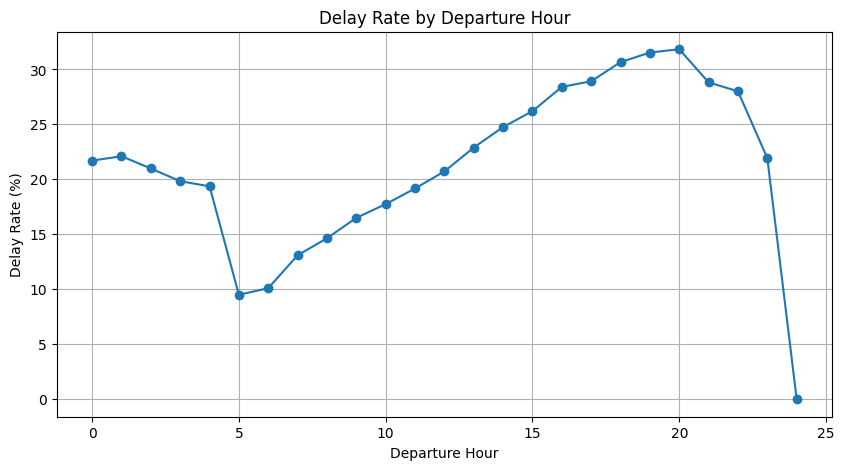

In [ ]:
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Delay Rate by Hour of Day
# ---------------------------------------------------

hourly_delay = df.groupBy("DepHour").agg(
    F.count("*").alias("flights"),
    F.mean("DelayLabel").alias("delay_rate")
).orderBy("DepHour")

hourly_pd = hourly_delay.toPandas()

plt.figure(figsize=(10,5))
plt.plot(hourly_pd["DepHour"],
         hourly_pd["delay_rate"]*100,
         marker="o")
plt.title("Delay Rate by Departure Hour")
plt.xlabel("Departure Hour")
plt.ylabel("Delay Rate (%)")
plt.grid(True)
plt.show()

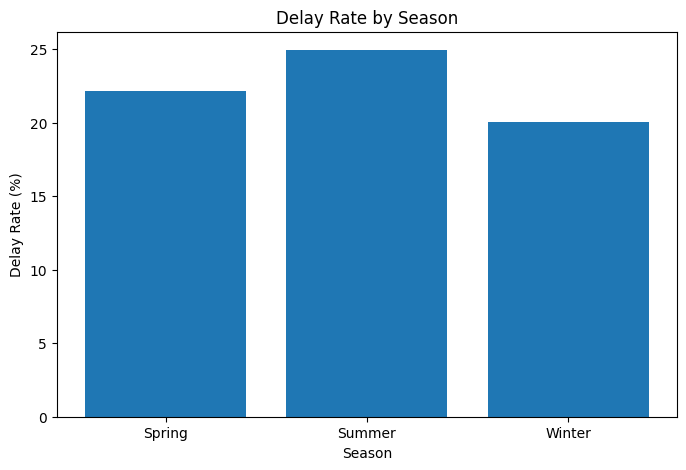

In [ ]:
# ---------------------------------------------------
# Delay Rate by Season
# ---------------------------------------------------

season_delay = df.groupBy("Season").agg(
    F.count("*").alias("flights"),
    F.mean("DelayLabel").alias("delay_rate")
)

season_pd = season_delay.toPandas()

plt.figure(figsize=(8,5))
plt.bar(season_pd["Season"],
        season_pd["delay_rate"]*100)
plt.title("Delay Rate by Season")
plt.xlabel("Season")
plt.ylabel("Delay Rate (%)")
plt.show()

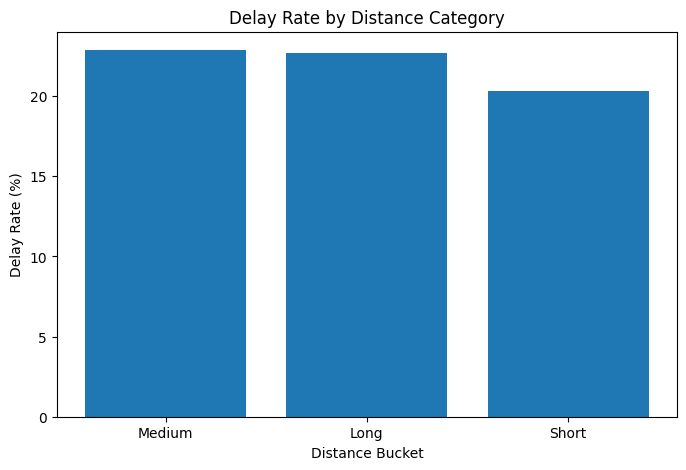

In [ ]:
# ---------------------------------------------------
# Delay Rate by Distance Bucket
# ---------------------------------------------------

distance_delay = df.groupBy("DistanceBucket").agg(
    F.count("*").alias("flights"),
    F.mean("DelayLabel").alias("delay_rate")
)

distance_pd = distance_delay.toPandas()

plt.figure(figsize=(8,5))
plt.bar(distance_pd["DistanceBucket"],
        distance_pd["delay_rate"]*100)
plt.title("Delay Rate by Distance Category")
plt.xlabel("Distance Bucket")
plt.ylabel("Delay Rate (%)")
plt.show()

**Encode & Assemble Features**

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, \
                               VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

indexers = [
    StringIndexer(inputCol="Reporting_Airline", outputCol="AirlineIdx",    handleInvalid="keep"),
    StringIndexer(inputCol="Origin",            outputCol="OriginIdx",      handleInvalid="keep"),
    StringIndexer(inputCol="Dest",              outputCol="DestIdx",        handleInvalid="keep"),
    StringIndexer(inputCol="TimeOfDay",         outputCol="TimeOfDayIdx",   handleInvalid="keep"),
    StringIndexer(inputCol="Season",            outputCol="SeasonIdx",      handleInvalid="keep"),
    StringIndexer(inputCol="DistanceBucket",    outputCol="DistBucketIdx",  handleInvalid="keep"),
]

encoders = [
    OneHotEncoder(inputCol="AirlineIdx",    outputCol="AirlineVec"),
    OneHotEncoder(inputCol="TimeOfDayIdx",  outputCol="TimeOfDayVec"),
    OneHotEncoder(inputCol="SeasonIdx",     outputCol="SeasonVec"),
    OneHotEncoder(inputCol="DistBucketIdx", outputCol="DistBucketVec"),
]

numerical_cols = [
    "Month", "DayofMonth", "DayOfWeek", "Quarter",
    "DepHour", "ArrHour", "CRSElapsedTime", "Distance",
    "DistanceGroup", "DepDelay", "DepDelayMinutes",
    "TaxiOut", "TaxiIn", "AirTime",
    "CarrierDelay", "WeatherDelay", "NASDelay",
    "SecurityDelay", "LateAircraftDelay",
    "RouteAvgDelay", "AirlineDelayRate",
    "IsWeekend", "IsHolidayMonth", "DelayRiskScore"
]

assembler = VectorAssembler(
    inputCols=numerical_cols + [
        "AirlineVec", "TimeOfDayVec", "SeasonVec", "DistBucketVec"
    ],
    outputCol="features",
    handleInvalid="skip"
)

scaler = StandardScaler(
    inputCol="features", outputCol="scaledFeatures",
    withMean=False, withStd=True
)

pipeline       = Pipeline(stages=indexers + encoders + [assembler, scaler])
pipeline_model = pipeline.fit(df)
df_scaled      = pipeline_model.transform(df)

print("Encoding + Scaling pipeline applied")
print("  Feature vector: 'features'")
print("  Scaled vector : 'scaledFeatures'")
print("  Total rows    :", df_scaled.count())

Encoding + Scaling pipeline applied
  Feature vector: 'features'
  Scaled vector : 'scaledFeatures'
  Total rows    : 3403465


**Train / Validation / Test Split**

In [ ]:
# Temporal split — prevents future data leaking into training
train_df = df_scaled.filter(F.col("Month").isin([1, 2, 3, 4]))
val_df   = df_scaled.filter(F.col("Month") == 5)
test_df  = df_scaled.filter(F.col("Month") == 6)

train_count = train_df.count()
val_count   = val_df.count()
test_count  = test_df.count()
total       = train_count + val_count + test_count

print("Temporal Split")
print(f"  Train (Jan–Apr): {train_count:,}  ({100*train_count/total:.1f}%)")
print(f"  Val   (May)    : {val_count:,}  ({100*val_count/total:.1f}%)")
print(f"  Test  (Jun)    : {test_count:,}  ({100*test_count/total:.1f}%)")

Temporal Split
  Train (Jan–Apr): 2,202,967  (64.7%)
  Val   (May)    : 599,226  (17.6%)
  Test  (Jun)    : 601,272  (17.7%)


**Checkpoint & Save Feature Splits**

In [ ]:
train_df.checkpoint()
val_df.checkpoint()
test_df.checkpoint()

train_df.write.mode("overwrite").parquet(FEATURES_PATH + "/train")
val_df.write.mode("overwrite").parquet(FEATURES_PATH + "/val")
test_df.write.mode("overwrite").parquet(FEATURES_PATH + "/test")

print("Feature splits saved:")
print("  Train:", FEATURES_PATH + "/train")
print("  Val  :", FEATURES_PATH + "/val")
print("  Test :", FEATURES_PATH + "/test")

Feature splits saved:
  Train: /content/drive/MyDrive/Machine Learning and Big Data/features_parquet/train
  Val  : /content/drive/MyDrive/Machine Learning and Big Data/features_parquet/val
  Test : /content/drive/MyDrive/Machine Learning and Big Data/features_parquet/test


**Tableau CSV: Dashboard 1 — Data Quality**

In [ ]:
# Feature completeness
total_rows   = df_scaled.count()
completeness = [(c,
                 df_scaled.filter(F.col(c).isNull()).count(),
                 round(100*(1 - df_scaled.filter(F.col(c).isNull()).count()/total_rows), 2))
                for c in numerical_cols]

spark.createDataFrame(completeness,
    ["feature","null_count","completeness_pct"]) \
    .coalesce(1).write.mode("overwrite") \
    .option("header","true") \
    .csv(TABLEAU_PATH + "/d1_feature_completeness")

# Train/Val/Test split
spark.createDataFrame([
    ("Train (Jan-Apr)", train_count, round(100*train_count/total,1)),
    ("Val (May)",       val_count,   round(100*val_count/total,  1)),
    ("Test (Jun)",      test_count,  round(100*test_count/total, 1)),
], ["split","rows","pct"]) \
    .coalesce(1).write.mode("overwrite") \
    .option("header","true") \
    .csv(TABLEAU_PATH + "/d1_train_val_test_split")

print("D1 CSVs saved: d1_feature_completeness, d1_train_val_test_split")

D1 CSVs saved: d1_feature_completeness, d1_train_val_test_split


**Tableau CSV: Dashboard 2 — Feature Importance**

In [ ]:
# Correlation of each numerical feature with DelayLabel
corr_rows = [(c, round(df_scaled.stat.corr(c, "DelayLabel"), 4))
             for c in numerical_cols]

spark.createDataFrame(corr_rows, ["feature","correlation_with_delay"]) \
    .orderBy(F.abs(F.col("correlation_with_delay")).desc()) \
    .coalesce(1).write.mode("overwrite") \
    .option("header","true") \
    .csv(TABLEAU_PATH + "/d2_feature_correlation")

# Class balance per split
spark.createDataFrame([
    ("Train", 0, train_df.filter(F.col("DelayLabel")==0).count()),
    ("Train", 1, train_df.filter(F.col("DelayLabel")==1).count()),
    ("Val",   0, val_df.filter(F.col("DelayLabel")==0).count()),
    ("Val",   1, val_df.filter(F.col("DelayLabel")==1).count()),
    ("Test",  0, test_df.filter(F.col("DelayLabel")==0).count()),
    ("Test",  1, test_df.filter(F.col("DelayLabel")==1).count()),
], ["split","label","rows"]) \
    .coalesce(1).write.mode("overwrite") \
    .option("header","true") \
    .csv(TABLEAU_PATH + "/d2_class_balance_by_split")

print("D2 CSVs saved: d2_feature_correlation, d2_class_balance_by_split")

D2 CSVs saved: d2_feature_correlation, d2_class_balance_by_split


**Tableau CSV: Dashboard 3 — Business Insights**

In [ ]:
# Delay rate by TimeOfDay and Season
df_scaled.groupBy("TimeOfDay","Season").agg(
    F.count("*").alias("flights"),
    F.round(F.mean("DelayLabel")*100, 2).alias("delay_rate_pct"),
    F.round(F.mean("ArrDelay"),       2).alias("avg_arr_delay_min")
).orderBy("Season","TimeOfDay") \
 .coalesce(1).write.mode("overwrite") \
 .option("header","true") \
 .csv(TABLEAU_PATH + "/d3_delay_by_time_season")

# Delay rate by DistanceBucket
df_scaled.groupBy("DistanceBucket").agg(
    F.count("*").alias("flights"),
    F.round(F.mean("DelayLabel")*100, 2).alias("delay_rate_pct"),
    F.round(F.mean("ArrDelay"),       2).alias("avg_arr_delay_min")
).orderBy("DistanceBucket") \
 .coalesce(1).write.mode("overwrite") \
 .option("header","true") \
 .csv(TABLEAU_PATH + "/d3_delay_by_distance_bucket")

# Risk score vs actual delay rate (custom transformer validation)
df_scaled.groupBy(F.round("DelayRiskScore", 1).alias("risk_bin")).agg(
    F.round(F.mean("DelayLabel")*100, 2).alias("actual_delay_rate_pct"),
    F.count("*").alias("flights")
).orderBy("risk_bin") \
 .coalesce(1).write.mode("overwrite") \
 .option("header","true") \
 .csv(TABLEAU_PATH + "/d3_risk_score_vs_actual")

print("D3 CSVs saved: d3_delay_by_time_season, d3_delay_by_distance_bucket,")
print("               d3_risk_score_vs_actual")

D3 CSVs saved: d3_delay_by_time_season, d3_delay_by_distance_bucket,
               d3_risk_score_vs_actual
